# **Goal: Classify weather or not a team player wins MotM Award.**

![https://imgur.com/a/MJAaE7W](http://)

**Index:** <br>
<br>
**1. Exploratory Data Analysis <br>**
        a. Feature Engineering <br>
        b. Graphs <br>

**2. Data Organising** <br>
        a. Dealing with Null Values <br>
        b. Dealing with Categorical Variables <br>
    
**3. Feature Importance Calculation** <br>
        a. XGBoost <br>
        b. LGBM <br>
        c. Extra Trees Classifier <br>
    
** 4. Training and Classification** <br>
        a. Support Vector Machine (RBF Kernel) <br>
        b. Linear Regression <br>
        c. Random Forests Classifier <br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = "whitegrid")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn import svm
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Exploratory Data Analysis

In [2]:
data = pd.read_csv("../input/FIFA 2018 Statistics.csv")
data.shape

(128, 27)

In [3]:
data.head(2)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN


> # Feature Engineering

Creating a feature of goals conceded by a team in a match using goals scored by the opposition

In [4]:
gc = np.array([], dtype = 'int')
for i in range(0, 128, 2):
    gc = np.append(gc, data.loc[i+1, "Goal Scored"])
    gc = np.append(gc, data.loc[i, "Goal Scored"])
    
data.insert(4, "Goal Conceded", pd.Series(gc))

In [5]:
data.head(2)

,Date,Team,Opponent,Goal Scored,Goal Conceded,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,0,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,5,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN


Creating a feature of who won the match using goals scored and goals conceded. <br> 
Attributes: Won, Lost, Draw (0, 1, 2) to keep no. of categories low 

In [6]:
conditions = [(data["Goal Scored"] > data["Goal Conceded"]), (data["Goal Scored"] == data["Goal Conceded"]), (data["Goal Scored"] < data["Goal Conceded"])]
result = np.array([0, 1, 2], dtype = 'int')
data.insert(5, "Result", pd.Series(np.select(conditions, result, default = -1)))

In [7]:
data.head(2)

,Date,Team,Opponent,Goal Scored,Goal Conceded,Result,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,0,0,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,5,2,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN


Creating a feature of total set pieces (free kicks + corners) <br>
(penalties ignored as information is not provided) 

In [8]:
data.insert(15, "Total Set Pieces", pd.Series(data["Corners"] + data["Free Kicks"], dtype = 'int'))


In [9]:
data.head(2)

,Date,Team,Opponent,Goal Scored,Goal Conceded,Result,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Total Set Pieces,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,0,0,40,13,7,3,3,6,3,11,0,17,78,306,118,22,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,5,2,60,6,0,3,3,2,1,25,2,27,86,511,105,10,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN


> # Graphs

Plot of Ball Possession vs Attempts. 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


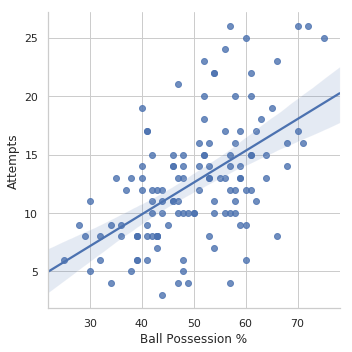

In [10]:
sns.lmplot(x = 'Ball Possession %', y = 'Attempts', data = data)

In [11]:
data["Ball Possession %"].corr(data["Attempts"], method = 'pearson')

0.5411851190090452

It can be observed that there is a linear relation between attempts made and % ball possession. <br>
Moreover, number of attempts tend to rise with increase in % ball possession. <br>
Correlation between % Ball Possession and Attempts: 0.54 (good correlation) <br>

Plot of Distance Covered vs Passes. 

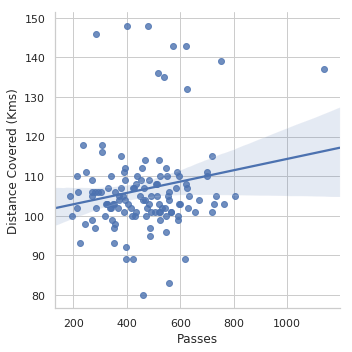

In [12]:
sns.lmplot(x = 'Passes', y = 'Distance Covered (Kms)', data = data)

In [13]:
data["Passes"].corr(data["Distance Covered (Kms)"], method = 'pearson')

0.18460146402248936

This is an interesting result. <br>
I thought there should be a good (inverse) correlation between passes and distance covered but it is very less.  <br>
Correlation between Passes and Distance Covered: 0.18 <br>

Comparison between number of set pieces for wins, losses and draws.

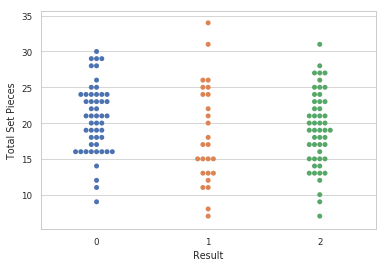

In [14]:
sns.set_context("paper")
sns.swarmplot( x = 'Result', y = 'Total Set Pieces', data = data)

This again is an corroborating conclusion. <br>
It was believed that this was the world cup of set pieces. <br> 
We can observe that more number of teams tend to win given equal number of set pieces. (0 and 1 on x-axis) <br>

# Data Organising

> # Dealing with Null Values

In [15]:
data.isna().sum()

Date                        0
Team                        0
Opponent                    0
Goal Scored                 0
Goal Conceded               0
Result                      0
Ball Possession %           0
Attempts                    0
On-Target                   0
Off-Target                  0
Blocked                     0
Corners                     0
Offsides                    0
Free Kicks                  0
Saves                       0
Total Set Pieces            0
Pass Accuracy %             0
Passes                      0
Distance Covered (Kms)      0
Fouls Committed             0
Yellow Card                 0
Yellow & Red                0
Red                         0
Man of the Match            0
1st Goal                   34
Round                       0
PSO                         0
Goals in PSO                0
Own goals                 116
Own goal Time             116
dtype: int64

In [16]:
data[['Own goals', 'Own goal Time']].head()

,Own goals,Own goal Time
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,1.0,90.0


As it can be seen, there were 116/2 = 58 matches in which either of the team did not score an own goal. <br>
Therefore, I replace NaN with 0 in both the columns, as it seems to be the most logical idea.

In [17]:
data[['Own goals', 'Own goal Time']] = data[['Own goals', 'Own goal Time']].fillna(0)
data.isna().sum()

Date                       0
Team                       0
Opponent                   0
Goal Scored                0
Goal Conceded              0
Result                     0
Ball Possession %          0
Attempts                   0
On-Target                  0
Off-Target                 0
Blocked                    0
Corners                    0
Offsides                   0
Free Kicks                 0
Saves                      0
Total Set Pieces           0
Pass Accuracy %            0
Passes                     0
Distance Covered (Kms)     0
Fouls Committed            0
Yellow Card                0
Yellow & Red               0
Red                        0
Man of the Match           0
1st Goal                  34
Round                      0
PSO                        0
Goals in PSO               0
Own goals                  0
Own goal Time              0
dtype: int64

In [18]:
data["1st Goal"].head()

0    12.0
1     NaN
2     NaN
3    89.0
4     NaN
Name: 1st Goal, dtype: float64

These are the matches in which one of the teams were not able to score a single score. <br>
Here, I replace NaN with full-time minutes as replacing it with 0 will give a different inference. <br>

In [19]:
data["1st Goal"] = data["1st Goal"].fillna(90)
data.isna().sum()

Date                      0
Team                      0
Opponent                  0
Goal Scored               0
Goal Conceded             0
Result                    0
Ball Possession %         0
Attempts                  0
On-Target                 0
Off-Target                0
Blocked                   0
Corners                   0
Offsides                  0
Free Kicks                0
Saves                     0
Total Set Pieces          0
Pass Accuracy %           0
Passes                    0
Distance Covered (Kms)    0
Fouls Committed           0
Yellow Card               0
Yellow & Red              0
Red                       0
Man of the Match          0
1st Goal                  0
Round                     0
PSO                       0
Goals in PSO              0
Own goals                 0
Own goal Time             0
dtype: int64

Now there are no Null or NaN values in the dataset.

> # Dealing with Categorical Variables

In [20]:
data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

There are features with Object, Integer and Float datatypes. <br>
We need to deal with features having Object datatype. <br>

In [21]:
cat = data.columns.values[data.dtypes == object]
cat

array(['Date', 'Team', 'Opponent', 'Man of the Match', 'Round', 'PSO'],
      dtype=object)

Out of these features: <br>
1. Date can be dropped. <br>
2. Team and Opponent contain names of countries. <br>
3. Man of the Match and PSO have values in Yes or No. <br>
4. Round has 6 different values. <br>

I'll deal with Team and Opponent separately.

In [22]:
data.drop(["Date"], axis = 1, inplace = True)

temp = np.array(['Man of the Match', 'Round', 'PSO'])
for i in range(0,len(temp)):
    x = temp[i]
    data[x] = data[x].astype('category').cat.codes
    
data.head(2)

,Team,Opponent,Goal Scored,Goal Conceded,Result,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Total Set Pieces,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,Russia,Saudi Arabia,5,0,0,40,13,7,3,3,6,3,11,0,17,78,306,118,22,0,0,0,1,12.0,2,0,0,0.0,0.0
1,Saudi Arabia,Russia,0,5,2,60,6,0,3,3,2,1,25,2,27,86,511,105,10,0,0,0,0,90.0,2,0,0,0.0,0.0


Therefore, Date is dropped. Man of the Match, Round and PSO is converted to categorical variables.

For Team and Opponent, I'll first get categorical codes for all the countries and then directly assign that codes to Team and Opponent.

In [23]:
# I am currently working on the above mentioned approach.
# This is a temporary solution.

data["Team"] = data["Team"].astype('category').cat.codes
data["Opponent"] = data["Opponent"].astype('category').cat.codes

In [24]:
data.head()

,Team,Opponent,Goal Scored,Goal Conceded,Result,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Total Set Pieces,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,23,24,5,0,0,40,13,7,3,3,6,3,11,0,17,78,306,118,22,0,0,0,1,12.0,2,0,0,0.0,0.0
1,24,23,0,5,2,60,6,0,3,3,2,1,25,2,27,86,511,105,10,0,0,0,0,90.0,2,0,0,0.0,0.0
2,8,31,0,1,2,43,8,3,3,2,0,1,7,3,7,78,395,112,12,2,0,0,0,90.0,2,0,0,0.0,0.0
3,31,8,1,0,0,57,14,4,6,4,5,1,13,3,18,86,589,111,6,0,0,0,1,89.0,2,0,0,0.0,0.0
4,17,13,0,1,2,64,13,3,6,4,5,0,14,2,19,86,433,101,22,1,0,0,0,90.0,2,0,0,1.0,90.0


# Now our data is clean and ready to train.

# Feature Importance Calculation

**I'll calculate feature importance using gradient boosting method.** <br>
1. XGBoost Classifier
2. Gradient Boosting Machince
3. Extra Trees Classifier <br>
After calculating feature importance using various algorithms, I'll select top 5 features consistent in each algortihm and finally train the actual model.

In [25]:
features = data.drop(["Man of the Match"], axis = 1)
target = data["Man of the Match"]

XGBoost Classifier

In [26]:
modelxgb = XGBClassifier()
modelxgb.fit(features, target)

print(modelxgb.feature_importances_)

[0.06331877 0.04803494 0.         0.03930131 0.15065502 0.04803494
 0.02183406 0.01528384 0.10262009 0.0371179  0.0742358  0.03275109
 0.04585153 0.01965065 0.06113537 0.0349345  0.06113537 0.03930131
 0.00655022 0.01746725 0.         0.         0.08078603 0.
 0.         0.         0.         0.        ]


Plot of F Scores (Feature Importance Scores) vs Features

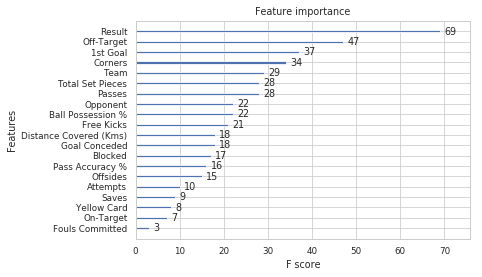

In [27]:
from xgboost import plot_importance
plot_importance(modelxgb)

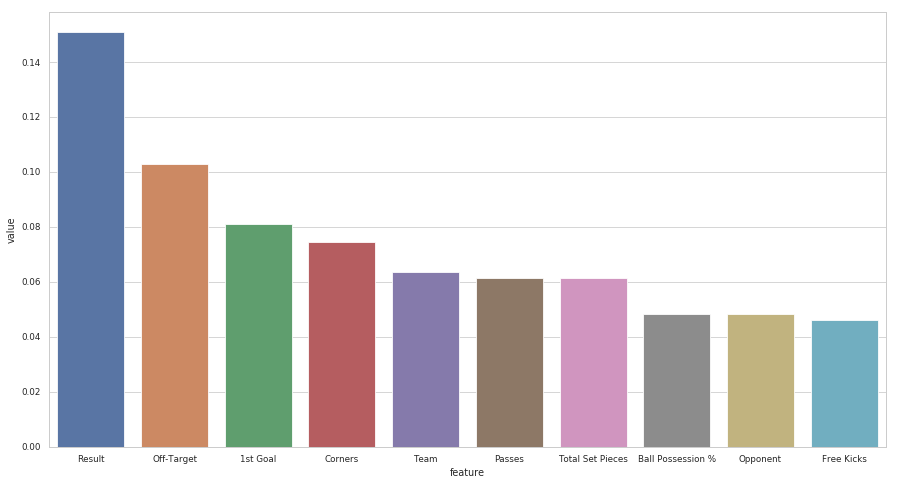

In [28]:
f_xgb = pd.DataFrame(data = {'feature' : features.columns, 'value' : modelxgb.feature_importances_})
f_xgb = f_xgb.sort_values(['value'], ascending = False)
top10xgb = f_xgb.head(10)
plt.figure(figsize=(15,8))
sns.barplot(x = top10xgb["feature"], y = top10xgb["value"])

In [29]:
modellgbm = LGBMClassifier()
modellgbm.fit(features, target)

print(modellgbm.feature_importances_)

[38 37  2 24 57  4 12 13 35 10 22  8 15  6 13 11  9 11  7 19  0  0 36  0
  0  0  0  0]


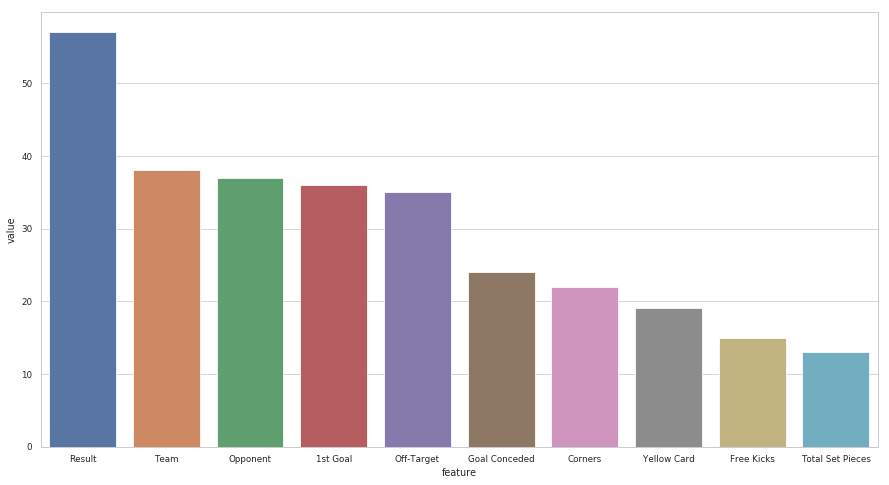

In [30]:
f_lgbm = pd.DataFrame(data = {'feature' : features.columns, 'value' : modellgbm.feature_importances_})
f_lgbm = f_lgbm.sort_values(['value'], ascending = False)
top10lgbm = f_lgbm.head(10)
plt.figure(figsize=(15,8))
sns.barplot(x = top10lgbm["feature"], y = top10lgbm["value"])

*Therefore, it can be observed that different algorithms give different Feature Importance Scores.*

**The 2 new features that were created in the begining are prominent for both, XGBoost and LGBM** <br>
**Infact, feature *"Result"*(as expected) is the most prominent and feature *"Total Set Pieces"* is also dominating**

*As I have used 2 boosting algorithms, I'll further use Extra Trees Classifier provided by sci-kit learn to obtain feature importance.*

In [31]:
modeletc = ExtraTreesClassifier()
modeletc.fit(features, target)

print(modeletc.feature_importances_)

[0.02084765 0.03085516 0.04312273 0.04763957 0.38807935 0.02351021
 0.0348496  0.01833547 0.03318647 0.02197854 0.02713149 0.01952792
 0.01912242 0.01718994 0.02809995 0.02031822 0.03348359 0.01073736
 0.01663112 0.02038266 0.         0.00144706 0.09800409 0.00583014
 0.00406126 0.00642282 0.00838283 0.00082237]


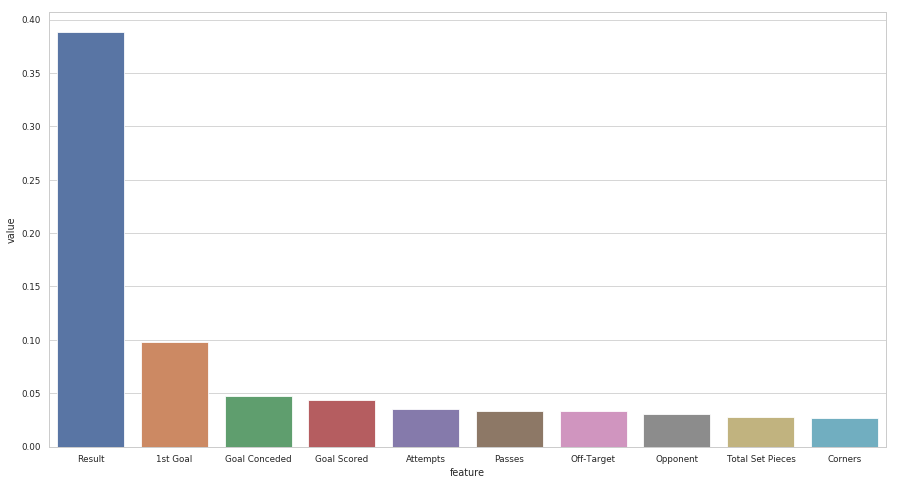

In [32]:
f_etc = pd.DataFrame(data = {'feature' : features.columns, 'value' : modeletc.feature_importances_})
f_etc = f_etc.sort_values(['value'], ascending = False)
top10etc = f_etc.head(10)
plt.figure(figsize=(15,8))
sns.barplot(x = top10etc["feature"], y = top10etc["value"])

**Again, feature *Result* is the most dominant feature.**

> # Now, based on these 3 algorithms, I will select top 5 features for training and prediction

Using intersection, I'll select all the features that are prevalent in all the three models.

In [33]:
ft = pd.merge(f_xgb, f_lgbm, how = 'inner', on = ["feature"])
ft = pd.merge(ft, f_etc, how = 'inner', on = ["feature"])

> Merging all the 3 feature importance dataframes, we get a comprehensive account of important features

In [34]:
ft.head(5)

,feature,value_x,value_y,value
0,Result,0.150655,57,0.388079
1,Off-Target,0.102620,35,0.033186
2,1st Goal,0.080786,36,0.098004
3,Corners,0.074236,22,0.027131
4,Team,0.063319,38,0.020848


Therefore, top 5 features are:
1. Result
2. Off-Target
3. 1st Goal
4. Corners
5. Team

Now, I'll use these features to train data and predict the target.

In [35]:
features = ft["feature"].head(5).values
X = data[features]
Y = target.values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 7)

**I am experimenting with Simple SVM (RBF Kernel), Logistic Regression and Random Forests.**

# Training and Classification

> # Support Vector Machine (Radial Basis Function)

In [37]:
modelsvc = svm.SVC(kernel = 'rbf', gamma='auto')
modelsvc.fit(X_train, y_train)
y_svc = modelsvc.predict(X_test)
accuracy_score(y_test, y_svc)

0.6666666666666666

We obtain 66% accuracy using SVM.

> # Logistic Regression

In [38]:
modelreg = linear_model.LogisticRegression()
modelreg.fit(X_train, y_train)
y_reg = modelreg.predict(X_test)
accuracy_score(y_test, y_reg.round(), normalize = False)

34

We obtain 34% accuracy using Logistic Regression Model. 

> # Random Forests Classifier

In [39]:
modelrf = RandomForestClassifier(max_depth=2, random_state=0)
modelrf.fit(X_train, y_train)
y_rf = modelrf.predict(X_test)
accuracy_score(y_test, y_rf)

0.8461538461538461

We obtain 84% accuracy using Random Forests Classifier. 

***Therefore, for this case, Random Forests Classifier prove to be the best classifier algorithm.***

# This is my first attempt to work on a data science and machine learning problem so please share your views and comments regarding this kernel so that I can improve my work. <br>
# A big thank you for taking out time and efforts to read through the entire kernel.